In [1]:
%load_ext autoreload
%autoreload

In [2]:
import torch as t
from torch import einsum
from torch import nn 
from einops import rearrange, reduce, repeat
import bert_tests
import math
import random
from collections import OrderedDict
import transformers
import torchtext
from tqdm import tqdm

Psudeocode for single head

raw_attention_pattern(activations, query_fn, key_fn):
    K = key_fn(activations)
    Q = query_fn(activations)
    return QK^T / sqrt(64)

In [3]:
def raw_attention_pattern(
    token_activations: t.Tensor,
    num_heads: int, 
    project_query,
    project_key
) -> t.Tensor:
    """
    inputs:
        token_activations: Tensor[batch_size, seq_length, hidden_size (768)],
        num_heads: int, 
        project_query: function( (Tensor[b, n, c: 768]) -> Tensor[b, n, (hn hs) : 768] ),
        project_key: function( (Tensor[..., 768]) -> Tensor[..., 768] 
    returns:
        Tensor[batch_size, head_num, key_token: seq_length, query_token: seq_length]
    """
    Q = rearrange(project_query(token_activations), "b n (hn hs) -> b hn n hs", hn = num_heads)
    K = rearrange(project_key(token_activations), "b n (hn hs) -> b hn n hs", hn = num_heads)
    ans = einsum("bhji,bhki->bhjk", K, Q)
    head_size = Q.shape[3]
    return ans / math.sqrt(head_size)

bert_tests.test_attention_pattern_fn(raw_attention_pattern)

attention pattern raw MATCH!!!!!!!!
 SHAPE (2, 12, 3, 3) MEAN: 0.008059 STD: 0.1069 VALS [0.004014 0.1631 0.1264 -0.02056 -0.15 -0.0257 0.04729 0.1093 -0.01661 0.0894...]


In [4]:
def bert_attention(
    token_activations: t.Tensor,
    num_heads: int, 
    attention_pattern: t.Tensor,
    project_value, 
    project_output,
):
    """
    input:
        token_activations: Tensor[batch_size, seq_length, hidden_size (768)], 
        num_heads: int, 
        attention_pattern: Tensor[batch_size,num_heads, seq_length, seq_length], 
        project_value: function( (Tensor[..., 768]) -> Tensor[..., 768] ), 
        project_output: function( (Tensor[..., 768]) -> Tensor[..., 768] )
    output:
        Tensor[batch_size, seq_length, hidden_size] 
    """
    attention_pattern = t.softmax(attention_pattern, dim = 2)
    V = rearrange(project_value(token_activations), "b n (hn hs) -> b hn n hs", hn = num_heads)
    A = rearrange(einsum('bhkq,bhki->bhqi',attention_pattern,V), "b hn n hs -> b n (hn hs)", hn = num_heads)
    return project_output(A)


bert_tests.test_attention_fn(bert_attention)




attention MATCH!!!!!!!!
 SHAPE (2, 3, 768) MEAN: -0.001797 STD: 0.1205 VALS [-0.2488 0.12 -0.05243 0.1049 -0.04674 -0.1931 0.07625 -0.2776 0.02127 -0.1898...]


In [5]:
class MultiHeadedSelfAttention(nn.Module):
    def __init__(self, num_heads = 12, hidden_size = 768):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_heads = num_heads
        self.Q = nn.Linear(hidden_size, hidden_size)
        self.K = nn.Linear(hidden_size, hidden_size)
        self.V = nn.Linear(hidden_size, hidden_size)
        self.O = nn.Linear(hidden_size, hidden_size)

    def forward(self, input):
        attention_pattern = raw_attention_pattern(input, self.num_heads, self.Q, self.K)
        return bert_attention(input, self.num_heads, attention_pattern, self.V, self.O)

bert_tests.test_bert_attention(MultiHeadedSelfAttention)

bert MATCH!!!!!!!!
 SHAPE (2, 3, 768) MEAN: -0.001554 STD: 0.1736 VALS [-0.08316 -0.09165 -0.03188 -0.03013 0.1001 0.09549 -0.1046 0.07742 0.0424 0.05553...]


In [6]:
def bert_mlp(
    token_activations: t.Tensor,
    linear_1: nn.Module,
    linear_2: nn.Module
):
    """
    input:
        token_activations: torch.Tensor[batch_size,seq_length,768],
        linear_1: nn.Module,
        linear_2: nn.Module
    output:
        torch.Tensor[batch_size, seq_length, 768]
    """
    return linear_2(nn.functional.gelu(linear_1(token_activations)))

bert_tests.test_bert_mlp(bert_mlp)


bert mlp MATCH!!!!!!!!
 SHAPE (2, 3, 768) MEAN: -0.0001934 STD: 0.1044 VALS [-0.1153 0.1189 -0.0813 0.1021 0.0296 0.06182 0.0341 0.1446 0.2622 -0.08507...]


In [7]:
class BertMLP(nn.Module):
    def __init__(self, input_size: int, intermediate_size:int):
        super().__init__()
        self.input_size = input_size
        self.intermediate_size = intermediate_size
        self.linear1 = nn.Linear(self.input_size, self.intermediate_size)
        self.linear2 = nn.Linear(self.intermediate_size, self.input_size)
    
    def forward(self, activations):
        return bert_mlp(activations, self.linear1, self.linear2)

In [8]:
class LayerNorm(nn.Module):
    def __init__(self, normalized_dim: int):
        super().__init__()
        self.normalized_dim = normalized_dim
        self.weight = nn.Parameter(t.ones([self.normalized_dim]))
        self.bias = nn.Parameter(t.zeros([self.normalized_dim]))
        self.eps = 1e-5
    
    def forward(self, input):
        mean = input.mean(dim=-1, keepdim=True).detach()
        var = input.var(dim=-1, keepdim=True, unbiased=False).detach()
        normed = (input-mean) / t.sqrt(var + self.eps)
        return normed*self.weight + self.bias

bert_tests.test_layer_norm(LayerNorm)


layer norm MATCH!!!!!!!!
 SHAPE (20, 10) MEAN: -1.431e-08 STD: 1.003 VALS [0.6906 -0.84 1.881 1.711 -0.5116 -0.9577 -0.1387 -0.6943 -0.6741 -0.4662...]


In [9]:
class BertBlock(nn.Module):
    def __init__(self, hidden_size:int, intermediate_size:int, num_heads:int, dropout:float):
        super().__init__()
        self.hidden_size = hidden_size
        self.intermediate_size = intermediate_size
        self.num_heads = num_heads

        self.attention = MultiHeadedSelfAttention(self.num_heads, self.hidden_size)
        self.ln1 = LayerNorm(self.hidden_size)
        self.mlp = BertMLP(self.hidden_size, self.intermediate_size)
        self.ln2 = LayerNorm(self.hidden_size)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, input):
        x = self.ln1(self.dropout1(self.attention(input)) + input)
        return self.ln2(self.dropout2(self.mlp(x)) + x)

bert_tests.test_bert_block(BertBlock)


bert MATCH!!!!!!!!
 SHAPE (2, 3, 768) MEAN: -5.381e-09 STD: 1 VALS [0.007132 -0.04372 0.6502 -0.5972 -1.097 0.7267 0.1275 -0.6035 -0.2226 0.2145...]


In [10]:
class Embedding(nn.Module):
    def __init__(self, vocab_size, embed_size):
        super().__init__()
        self.vocab_size = vocab_size
        self.embed_size = embed_size
        self.weight = nn.Parameter(t.randn((self.vocab_size, self.embed_size)))

    def forward(self, input):
        return self.weight[input]

bert_tests.test_embedding(Embedding)

embedding MATCH!!!!!!!!
 SHAPE (2, 3, 5) MEAN: -0.06748 STD: 1.062 VALS [1.176 -0.1914 0.8212 1.047 -0.481 0.7106 -1.304 -1.307 -0.438 -0.2764...]


In [11]:
def bert_embedding(
    input_ids, 
    token_type_ids, 
    position_embedding: Embedding,
    token_embedding: Embedding, 
    token_type_embedding: Embedding, 
    layer_norm: LayerNorm, 
    dropout: nn.Dropout
):
    """
    input:
        input_ids: [batch, seqlen], 
        token_type_ids: [batch, seqlen], 
        position_embedding: Embedding,
        token_embedding: Embedding, 
        token_type_embedding: Embedding, 
        layer_norm: LayerNorm, 
        dropout: nn.Dropout)
    returns:

    """
    pos_ids = repeat(t.arange(input_ids.shape[1]), 's -> b s', b = input_ids.shape[0]).to(input_ids.device) 
    x = token_embedding(input_ids) + token_type_embedding(token_type_ids) + position_embedding(pos_ids)
    return dropout(layer_norm(x))

bert_tests.test_bert_embedding_fn(bert_embedding)

bert embedding MATCH!!!!!!!!
 SHAPE (2, 3, 768) MEAN: 8.278e-10 STD: 1 VALS [-1.319 -0.4378 -2.074 0.9679 0.9274 1.479 -0.501 -1.9 -0.212 0.7961...]


In [12]:
class BertEmbedding(nn.Module):
    def __init__(self, vocab_size:int, hidden_size:int, max_position_embeddings:int, type_vocab_size:int, dropout:float):
        super().__init__()
        self.vocab_size = vocab_size
        self.hidden_size = hidden_size
        self.max_position_embeddings = max_position_embeddings
        self.type_vocab_size = type_vocab_size
        self.token_embedding = Embedding(self.vocab_size, self.hidden_size)
        self.position_embedding = Embedding(self.max_position_embeddings, self.hidden_size)
        self.token_type_embedding = Embedding(self.type_vocab_size, self.hidden_size)
        self.layer_norm = LayerNorm(self.hidden_size) 
        self.dropout = nn.Dropout(dropout)

    def forward(self, input_ids, token_type_ids):
        return bert_embedding(input_ids, token_type_ids,
            self.position_embedding, self.token_embedding,
            self.token_type_embedding, self.layer_norm, self.dropout) 

bert_tests.test_bert_embedding(BertEmbedding)

bert embedding MATCH!!!!!!!!
 SHAPE (2, 3, 768) MEAN: 2.07e-10 STD: 1 VALS [-0.009385 -0.4919 0.9852 -0.3535 -3.624 1.333 1.163 1.449 1.063 0.246...]


In [13]:
class Bert(nn.Module):
    def __init__(self, vocab_size: int, hidden_size: int, 
        max_position_embeddings: int, type_vocab_size: int, 
        dropout: float, intermediate_size: int, num_heads: int, 
        num_layers: int
    ):
        super().__init__()
        self.dropout = dropout
        self.hidden_size = hidden_size
        self.embedding = BertEmbedding(vocab_size, hidden_size, max_position_embeddings, type_vocab_size, dropout)
        self.transformer = nn.Sequential(
            *[BertBlock(hidden_size, intermediate_size, num_heads, dropout) for i in range(num_layers)],
        )
        self.lm_head = nn.Sequential(OrderedDict([
            ["mlp", nn.Linear(hidden_size, hidden_size)],
            ["gelu", nn.GELU()],
            ["layer_norm" , LayerNorm(hidden_size)],
            ["unembedding", nn.Linear(hidden_size, vocab_size)],
        ]))
    
    def forward(self, input_ids):
        token_type_ids = t.zeros_like(input_ids)
        return self.lm_head(self.transformer(self.embedding(input_ids, token_type_ids)))
    

bert_tests.test_bert(Bert)


bert MATCH!!!!!!!!
 SHAPE (1, 4, 28996) MEAN: 0.003031 STD: 0.5765 VALS [-0.5742 -0.432 0.1186 -0.7165 -0.5261 0.4967 1.223 0.3165 -0.3247 -0.5716...]


In [14]:
my_bert = Bert(
    vocab_size=28996, hidden_size=768, max_position_embeddings=512, 
    type_vocab_size=2, dropout=0.1, intermediate_size=3072, 
    num_heads=12, num_layers=12
)
pretrained_bert = bert_tests.get_pretrained_bert()

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
def key_map(old_key):
    key_segments = old_key.split(".")
    if key_segments[0] == "transformer":
        if key_segments[2] == 'layer_norm':
            key_segments[2] = 'ln1'
        elif key_segments[2] == 'attention':
            if key_segments[3] == 'pattern':
                del key_segments[3]
            key_segments[3] = {
                "project_query": "Q",
                "project_key": "K",
                "project_value": "V",
                "project_out": "O",
            }[key_segments[3]]
        elif key_segments[2] == 'residual':
            if key_segments[3] == 'mlp1':
                key_segments[2] = 'mlp'
                key_segments[3] = 'linear1'
            elif key_segments[3] == 'mlp2':
                key_segments[2] = 'mlp'
                key_segments[3] = 'linear2'
            elif key_segments[3] == 'layer_norm':
                del key_segments[2]
                key_segments[2] = 'ln2'

    return ".".join(key_segments)

def skip_key(old_key: str):
    return old_key.startswith("classification_head")

remapped_keys = set([key_map(k) for k in pretrained_bert.state_dict().keys()])
target_keys = my_bert.state_dict().keys()

def split_and_filter(k):
    segs = k.split(".")
    # if segs[0] == "transformer" and segs[1] == '0':
    print(segs)

print("----  Extra Keys  ----")

for k in remapped_keys - target_keys:
    split_and_filter(k)

print("----  Missing Keys  ----")

for k in target_keys - remapped_keys:
    split_and_filter(k)

# for k in my_bert.state_dict().keys():
#     key_segments = k.split(".")
#     if key_segments[0] == "transformer":
#         if key_segments[1] == '0':
#             print(key_segments)




----  Extra Keys  ----
['classification_head', 'bias']
['classification_head', 'weight']
----  Missing Keys  ----


In [ ]:
def transfer_weights(pretrained, ours, strict = True):
    ours.load_state_dict({
        key_map(k): v 
        for k, v in pretrained.state_dict().items()
        if not skip_key(k)
    }, strict = strict)

transfer_weights(pretrained_bert, my_bert)

In [ ]:
bert_tests.test_same_output(my_bert, pretrained_bert)

comparing Berts MATCH!!!!!!!!
 SHAPE (10, 20, 28996) MEAN: -2.732 STD: 2.413 VALS [-5.65 -6.041 -6.096 -6.062 -5.946 -5.777 -5.977 -6.015 -6.028 -5.935...]


In [ ]:
tokenizer = transformers.AutoTokenizer.from_pretrained("bert-base-cased")
def ascii_art_probs(inp, k = 5):
    input_list = tokenizer(inp)['input_ids']
    mask_id = input_list.index(103)
    input_ids = t.tensor([input_list])
    out = my_bert(input_ids)
    soft = t.softmax(out[0,mask_id,:], dim = 0)
    vals, inds = t.topk(soft, k, dim = 0)
    print(inp.replace('[MASK]', '___'))
    mask_location = inp.index('[MASK]')
    preds = [f"{vals[i]:.0%}".rjust(mask_location-1) + ' ' + tokenizer.decode(inds[i]) for i in range(k)]
    print('\n'.join(preds))

In [ ]:
ascii_art_probs("58 + 12 = [MASK].")

58 + 12 = ___.
      10% 0
      10% 1
       6% 2
       4% 3
       4% 4


In [ ]:
class BertClassifier(Bert):
    def __init__(self, num_classes, **kwargs):
        super().__init__(**kwargs)
        self.num_classes = num_classes
        self.class_head = nn.Sequential(
            nn.Dropout(self.dropout),
            nn.Linear(self.hidden_size, self.num_classes)
        )

    def forward(self, input_ids):
        token_type_ids = t.zeros_like(input_ids)
        trans_out = self.transformer(self.embedding(input_ids, token_type_ids))
        class_logits = self.class_head(trans_out)[:, 0, :]
        return self.lm_head(trans_out), class_logits

bert_tests.test_bert_classification(BertClassifier)

bert MATCH!!!!!!!!
 SHAPE (1, 4, 28996) MEAN: 0.003031 STD: 0.5765 VALS [-0.5742 -0.432 0.1186 -0.7165 -0.5261 0.4967 1.223 0.3165 -0.3247 -0.5716...]
bert MATCH!!!!!!!!
 SHAPE (1, 2) MEAN: 0.09479 STD: 1.411 VALS [-0.903 1.093]


In [ ]:
data_train, data_test = torchtext.datasets.IMDB(root='.data', split=('train', 'test'))
data_train = list(data_train)
data_test = list(data_test)

In [ ]:
def process_data(data_set: list, batch_size=16, max_seq_length=512, num_batches = None):
    def process_element(el):
        sentiment, review = el
        numerical_sent = 1 if sentiment=="pos" else 0
        tokens = tokenizer(review)['input_ids']
        tokens = tokens[:max_seq_length - 1] + [102] if len(tokens) > max_seq_length - 1 else tokens
        return numerical_sent, tokens

    def pad(tokens, pad_length):
        return tokens + [0]*(pad_length - len(tokens)) 

    def make_batch(start_idx, data_set):
        batch_data =[process_element(el) for el in data_set[start_idx:start_idx+batch_size]]
        longest = max([len(tokens) for _, tokens in batch_data])
        token_tensor = t.tensor([pad(tokens, longest) for _, tokens in batch_data])
        sent_tensor = t.tensor([sent for sent, _ in batch_data])
        return (token_tensor, sent_tensor)

    data_set.sort(key= lambda tup: len(tup[1]), reverse=True)
    batch_start_idxs = list(range(0, len(data_set), batch_size))
    random.shuffle(batch_start_idxs)
    if num_batches is None:
        return (make_batch(idx, data_set) for idx in batch_start_idxs)
    else:
        return (make_batch(idx, data_set) for idx in batch_start_idxs[:num_batches])

In [ ]:
device = "cuda" if t.cuda.is_available() else "cpu"

def eval_classifier(model, data_test):
    model.eval()
    CE_Loss = nn.CrossEntropyLoss()

    batched_test = process_data(data_test)
    test_losses = []
    for batch_data, batch_sentiment in batched_test:
        batch_data.to(device)
        batch_sentiment.to(device)
        _, pred_class_logits = model(batch_data) # pred_class_logits: [batch, classes]
        loss = CE_Loss(pred_class_logits, batch_sentiment).detach().item()
        test_losses.append(loss)
    
    return sum(test_losses)/len(test_losses)

def train_sentiment_classifier(model, data_train: list, data_test: list, lr=1e-5, epochs=1):
    opt = t.optim.Adam(model.parameters(), lr=lr)
    CE_Loss = nn.CrossEntropyLoss()
    
    for epoch in range(epochs):
        batched_train = process_data(data_train)

        model.train()
        for batch_data, batch_sentiment in tqdm(batched_train):
            batch_data.to(device)
            batch_sentiment.to(device)
            opt.zero_grad()
            _, pred_class_logits = model(batch_data) # pred_class_logits: [batch, classes]
            loss = CE_Loss(pred_class_logits, batch_sentiment)
            loss.backward()
            opt.step()
            print(t.cuda.memory_allocated(0))

        print("epoch done")
        print(t.cuda.memory_allocated(0))
        test_loss = eval_classifier(model, data_test)
        print(f"epoch {epoch}/{epochs}: {test_loss:.2f}")

    model.eval()

our_bert_classifier = BertClassifier(num_classes = 2, vocab_size=28996, hidden_size=768, max_position_embeddings=512, 
    type_vocab_size=2, dropout=0.1, intermediate_size=3072, 
    num_heads=12, num_layers=12)
transfer_weights(pretrained_bert, our_bert_classifier, strict = False)
our_bert_classifier.to(device)

train_sentiment_classifier(our_bert_classifier, data_train, data_test)

RuntimeError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 47.54 GiB total capacity; 45.07 GiB already allocated; 10.75 MiB free; 45.22 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
device = "cuda" if t.cuda.is_available() else "cpu"

def eval_classifier(model, data_test, batch_size):
    model.eval()
    CE_Loss = nn.CrossEntropyLoss()

    batched_test = process_data(data_test, batch_size=batch_size, num_batches = 10)
    test_losses = []
    acc_cnt = 0
    tot_cnt = 0
    for batch_data, batch_sentiment in batched_test:
        batch_data = batch_data.to(device)
        batch_sentiment = batch_sentiment.to(device)
        _, pred_class_logits = model(batch_data) # pred_class_logits: [batch, classes]
        loss = CE_Loss(pred_class_logits, batch_sentiment).detach().item()
        test_losses.append(loss)
        acc_cnt += (t.argmax(pred_class_logits, dim = 1) == batch_sentiment).sum()
        tot_cnt += batch_data.shape[0] 
    
    return sum(test_losses)/len(test_losses), acc_cnt/tot_cnt 

def train_sentiment_classifier(model, data_train: list, data_test: list, lr=5e-6, epochs=30, batch_size = 16):
    opt = t.optim.Adam(model.parameters(), lr=lr)
    CE_Loss = nn.CrossEntropyLoss()
    losses = []
    acc = []
    for epoch in range(epochs):
        batched_train = process_data(data_train, batch_size=batch_size, num_batches = 100)

        for batch_data, batch_sentiment in tqdm(batched_train):
            model.train()
            batch_data = batch_data.to(device)
            batch_sentiment = batch_sentiment.to(device)
            opt.zero_grad()
            _, pred_class_logits = model(batch_data) # pred_class_logits: [batch, classes]
            loss = CE_Loss(pred_class_logits, batch_sentiment)
            loss.backward()
            opt.step()

        print("epoch done")
        test_loss, pred_acc = eval_classifier(model, data_test, batch_size)
        losses.append(test_loss)
        acc.append(pred_acc)
        print(f"epoch {epoch}/{epochs}: {test_loss:.2f}")

    model.eval()
    return losses, acc

our_bert_classifier = BertClassifier(num_classes = 2, vocab_size=28996, hidden_size=768, max_position_embeddings=512, 
    type_vocab_size=2, dropout=0.1, intermediate_size=3072, 
    num_heads=12, num_layers=12)
transfer_weights(pretrained_bert, our_bert_classifier, strict = False)
our_bert_classifier.to(device)

losses, acc = train_sentiment_classifier(our_bert_classifier, data_train, data_test)


In [ ]:
fun_data = data_test[22000] 
tokenized = process_data([fun_data], batch_size = 1)
d, s = next(tokenized)
our_bert_classifier.eval()
print(f"pos prob: {t.softmax(our_bert_classifier(d)[1], dim = 1)[0][1].item():.2%}") 
print(fun_data[1], fun_data[0])

(8, 28288, 196)

In [ ]:
wiki_data_train, wiki_data_valid, wiki_data_test = torchtext.datasets.WikiText2(root='.data', split=('train', 'valid', 'test'))
wiki_data_train = list(wiki_data_train)
wiki_data_valid = list(wiki_data_valid)
wiki_data_test = list(wiki_data_test)
random.shuffle(wiki_data_train)
random.shuffle(wiki_data_valid)
random.shuffle(wiki_data_test)


196

In [ ]:
def process_mask_data(data_set: list, batch_size=16, max_seq_length=512, num_batches = None):
    def process_element(el):
        tokens = tokenizer(el)['input_ids']
        tokens = tokens[:max_seq_length - 1] + [102] if len(tokens) > max_seq_length - 1 else tokens
        tokens = t.tensor(tokens)
        tmp_rand = t.rand(size = tokens.shape)
        tmp_rand_int = t.randint(low = 0, high = 28996, size = tokens.shape)
        predict = (tmp_rand < 0.15).bool()
        original_tokens = tokens.detach().clone() 
        tokens = t.where(tmp_rand < 0.12, tokenizer.mask_token_id, tokens)
        tokens = t.where((0.12 <= tmp_rand) & (tmp_rand < 0.135), tmp_rand_int, tokens)
        return tokens, predict, original_tokens

    def pad(tokens, pad_length):
        return t.cat((tokens, t.zeros((pad_length - tokens.shape[0]), dtype = tokens.dtype)))

    def make_batch(start_idx, data_set):
        batch_data =[process_element(el) for el in data_set[start_idx:start_idx+batch_size]]
        longest = max([tokens.shape[0] for tokens,_,__ in batch_data])
        #print(longest, batch_data)
        # print(longest)
        # for tokens, predict, original in batch_data:
        #     print(tokens[:10])
        #     print(pad(tokens, longest))
            
        token_tensor = t.stack([pad(tokens, longest) for tokens, _p, _o in batch_data])
        predict_tensor = t.stack([pad(predict, longest) for _t, predict, _o in batch_data])
        original_tensor = t.stack([pad(original, longest) for _t, _p, original in batch_data])
        return (token_tensor, predict_tensor, original_tensor)

    data_set.sort(key = lambda s: len(s), reverse=True)
    batch_start_idxs = list(range(0, len(data_set), batch_size))
    random.shuffle(batch_start_idxs)
    if num_batches is None:
        return (make_batch(idx, data_set) for idx in batch_start_idxs)
    else:
        return (make_batch(idx, data_set) for idx in batch_start_idxs[:num_batches])

In [ ]:
tiny_bert = Bert(
    vocab_size=28996, hidden_size=384, max_position_embeddings=512, 
    type_vocab_size=2, dropout=0.1, intermediate_size=1536, 
    num_heads=12, num_layers=2
)

515814

(array([10., 12., 37., 33., 22., 16., 12.,  9.,  8., 37.]),
 array([ 41. ,  88.1, 135.2, 182.3, 229.4, 276.5, 323.6, 370.7, 417.8,
        464.9, 512. ]),
 <BarContainer object of 10 artists>)

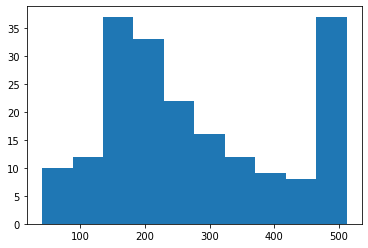

In [ ]:
device = "cuda" if t.cuda.is_available() else "cpu"

def masked_loss(model, batch):
    batch_token, batch_pred, batch_original = batch
    logsoft = nn.LogSoftmax(dim = 2)
    batch_token = batch_token.to(device)
    batch_pred = batch_pred.to(device)
    batch_original = batch_original.to(device)
    if not t.any(batch_pred):
        return None
    out = model(batch_token)
    ls = rearrange(logsoft(out), 'b n v -> v b n')[batch_original]
    logprobs_of_correct_tokens = t.masked_select(ls, batch_pred)
    return -logprobs_of_correct_tokens.mean()
    

def train_our_bert(model, data_train, data_test, lr = 0.001, epochs = 30):
    opt = t.optim.Adam(model.parameters(), lr = lr)
    for epoch in range(epochs):
        batches = process_mask_data(data_train)
        model.train()
        train_loss = 0
        train_cnt_batches = 0
        for b in batches:
            opt.zero_grad()
            loss = masked_loss(model, b)
            if loss is None:
                continue 
            loss.backward()
            opt.step()
            train_loss += loss.detach().item()
            train_cnt_batches += 1
        print(f"train loss epoch {epoch+1}: {train_loss/train_cnt_batches}")
        
        model.eval()
        batches = process_mask_data(data_test, num_batches = 50)
        tot_loss = 0
        cnt_batches = 0
        for b in batches:
            loss = masked_loss(model, b)
            if loss is None:
                continue 
            tot_loss += loss
            cnt_batches += 1
        print(f"test loss epoch {epoch+1}: {(tot_loss/cnt_batches).item()}") 
        

tiny_bert.to(device)
train_our_bert(tiny_bert, wiki_data_train, wiki_data_test)